In [1]:
import pandas as pd
import numpy as np

In [2]:
path = 'c:/data/elo/'
train_path = 'train.csv'
test_path = 'test.csv'
historical_transactions_path = 'historical_transactions.csv'
new_merchant_transactions_path = 'new_merchant_transactions.csv'
merchants_path= 'merchants.csv'

In [3]:
%matplotlib inline

In [4]:
import telepot
def send_notify(text):
    with open('../../_access_keys/telegram_token.txt', 'r') as content_file:
        token = content_file.read()
    with open('../../_access_keys/user.txt', 'r') as content_file:
        user = content_file.read()
    try:
        TelegramBot = telepot.Bot(token)
        TelegramBot.sendMessage(int(user), text)
    except:
        pass

In [5]:
from keras.callbacks import Callback
from matplotlib import pyplot as plt
from IPython.display import clear_output
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True,figsize=(15,10))
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="validation loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input, GlobalMaxPooling1D, GRU, Bidirectional, LSTM, concatenate
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras import regularizers

# analyze

In [8]:
train = pd.read_csv(path + train_path)

In [9]:
train.shape

(201917, 6)

In [10]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [11]:
train['feature_3'].unique()

array([1, 0], dtype=int64)

In [12]:
test = pd.read_csv(path + test_path)

In [13]:
test.shape

(123623, 5)

In [14]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
3,2017-12,C_ID_d27d835a9f,2,1,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1


## historical_transactions 

In [15]:
historical_transactions = pd.read_csv(path + historical_transactions_path)

In [16]:
historical_transactions.shape

(29112361, 14)

In [17]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [18]:
historical_transactions['subsector_id'].unique()

array([37, 16, 34, 41, 29,  7, 33,  2, 36, 25, 15, 19, 10, 30, 18,  8, 27,
        1, 39, 32, 22, 20, 21,  9, 17, 38, 12, 26, 31, 13, 35,  5, 23,  3,
        4, 14, 24, 40, 11, -1, 28], dtype=int64)

## new_merchant_transactions 

In [19]:
new_merchant_transactions = pd.read_csv(path + new_merchant_transactions_path)

In [20]:
new_merchant_transactions.shape

(1963031, 14)

In [21]:
new_merchant_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [22]:
new_merchant_transactions['subsector_id'].unique()

array([19, 14,  8, 29, 16, 10, 37, 15, 18, 34, 22, 27,  3,  1, 33, 20, 21,
       36,  7, 39, 41, 38, 32, 12,  2, 17, 30, 31, 25,  9, 11, 26, 35, 24,
        4,  5, 13, 23, 40, -1, 28], dtype=int64)

## merchants 

In [23]:
merchants = pd.read_csv(path + merchants_path)

In [24]:
merchants.shape

(334696, 22)

In [25]:
merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [26]:
merchants['most_recent_sales_range'].unique()

array(['E', 'C', 'D', 'A', 'B'], dtype=object)

# train

In [120]:
X = train[['feature_1', 'feature_2', 'feature_3']]

In [121]:
y = train['target']

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [131]:
X_train.describe()

,feature_1,feature_2,feature_3
count,161533.000000,161533.000000,161533.000000
mean,3.104313,1.745451,0.564665
std,1.186506,0.751393,0.495802
min,1.000000,1.000000,0.000000
25%,2.000000,1.000000,0.000000
50%,3.000000,2.000000,1.000000
75%,4.000000,2.000000,1.000000
max,5.000000,3.000000,1.000000


In [123]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [149]:
def create_model():
    #build Keras model
    
    x_input = Input(shape=X_train.shape[1:], dtype='float32')

    x_layer = Dense(X_train.shape[-1], activation="relu", kernel_initializer="normal")(x_input)
    x_layer = Dense(1, activation="relu", kernel_initializer="normal")(x_layer)

    model = Model(x_input, x_layer)
    model.compile(loss='mean_squared_error', metrics=['mae'], optimizer='rmsprop')
    return model

In [150]:
count_epochs = 100
model = create_model()
early_stopping_monitor = EarlyStopping(patience=10)
history = model.fit(np.array(X_train), np.array(y_train), batch_size = 64, epochs = count_epochs, verbose=1, validation_split=0.2, callbacks=[early_stopping_monitor])

Train on 129226 samples, validate on 32307 samples
Epoch 1/100
129226/129226 [==============================] - 3s 22us/step - loss: 14.9865 - mean_absolute_error: 1.5449 - val_loss: 14.7089 - val_mean_absolute_error: 1.5313
Epoch 2/100
129226/129226 [==============================] - 2s 19us/step - loss: 14.9865 - mean_absolute_error: 1.5449 - val_loss: 14.7089 - val_mean_absolute_error: 1.5313
Epoch 3/100
129226/129226 [==============================] - 2s 19us/step - loss: 14.9865 - mean_absolute_error: 1.5449 - val_loss: 14.7089 - val_mean_absolute_error: 1.5313
Epoch 4/100
129226/129226 [==============================] - 2s 19us/step - loss: 14.9865 - mean_absolute_error: 1.5449 - val_loss: 14.7089 - val_mean_absolute_error: 1.5313
Epoch 5/100
129226/129226 [==============================] - 2s 19us/step - loss: 14.9865 - mean_absolute_error: 1.5449 - val_loss: 14.7089 - val_mean_absolute_error: 1.5313
Epoch 6/100
129226/129226 [==============================] - 2s 19us/step - los

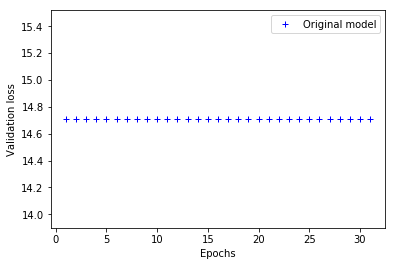

In [151]:
history_gr = history.history['val_loss']
epochs = range(1, len(history_gr) + 1)
import matplotlib.pyplot as plt

plt.plot(epochs, history_gr, 'b+', label='Original model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

In [155]:
predict = model.predict(np.array(X_test))
score = root_mean_squared_error(y_test, predict[0])
print("Total roc auc score = {0:0.4f}".format(score))

TypeError: unsupported format string passed to Tensor.__format__

In [157]:
predict.max()

0.0